#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_squared_error
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


Проверим временной ряд на монотонность

In [3]:
data.index.is_monotonic

True

Никаких скачков нет, двигаемся дальше!

In [4]:
data = data.resample('1H').sum()
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


Итак, данные корректно загружены, проверены и ресэмплированы по часам.  
Можем приступать к анализу.

## Анализ

Анализируя временной ряд, взглянем на тренд и сезонность.

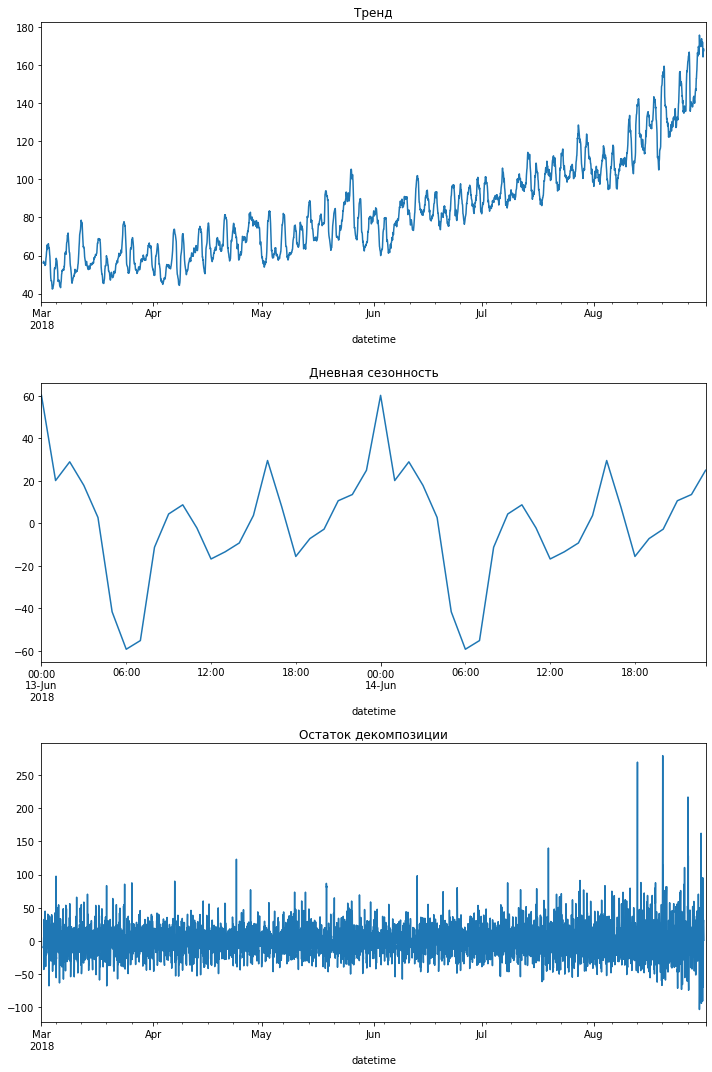

In [6]:
decompose = seasonal_decompose(data)

plt.figure(figsize=(10,15))
plt.subplot(311)

decompose.trend.plot(ax=plt.gca())
plt.title('Тренд')
plt.subplot(312)

decompose.seasonal['2018-06-13':'2018-06-14'].plot(ax=plt.gca())
plt.title('Дневная сезонность')
plt.subplot(313)

decompose.resid.plot(ax=plt.gca())
plt.title('Остаток декомпозиции')

plt.tight_layout()

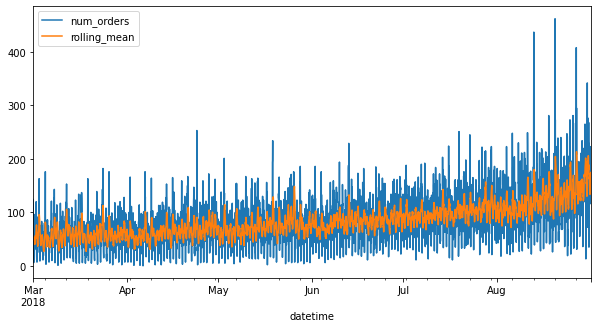

In [7]:
data['rolling_mean'] = data.rolling(10).mean()

data.plot(figsize=(10,5))
plt.show()

Тренд указывает на увеличение заказов.  
А сезоность - на высокий спрос на такси в ночное время.

Выходит, что стохастический процесс нестационарный.

## Обучение
### Подготовка данных для обучения

In [8]:
def make_features(data, max_lag, rolling_mean_size):
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

In [9]:
make_features(data, 30, 10)
data.head()

,num_orders,rolling_mean,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,...,lag_21,lag_22,lag_23,lag_24,lag_25,lag_26,lag_27,lag_28,lag_29,lag_30
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,NaN,3,0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,NaN,3,1,124.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,NaN,3,2,85.0,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,NaN,3,3,71.0,85.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,NaN,3,4,66.0,71.0,85.0,124.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
print(data.shape)
data = data.dropna()
print(data.shape)

(4416, 34)
(4386, 34)


In [11]:
train, test = train_test_split(data, shuffle=False, test_size=0.1)

features_train = train.drop('num_orders', axis=1)
target_train = train['num_orders']

features_test = test.drop('num_orders', axis=1)
target_test = test['num_orders']

print(train.shape, test.shape)

(3947, 34) (439, 34)


### Кросс-валидация
Сначала подготовим функцию для кросс-валидации на временных рядах, а затем будем использовать её, предварительно подбирая параметры с помощью обычного GridSearchCV

In [12]:
max_size = (train.shape[0]*4//5)
cv = 3

def cv_time_series_rmse(estimator, data=train, target='num_orders',
                        n_splits=cv, max_train_size=max_size):
    tscv = TimeSeriesSplit(n_splits=n_splits, max_train_size=max_train_size)
    rmse = 0.0
    
    for train_index, test_index in tscv.split(data):
        train_cv = data.iloc[train_index]
        test_cv = data.iloc[test_index]
        
        features_train_cv = train_cv.drop(target, axis=1)
        target_train_cv = train_cv[target]
        features_test_cv = test_cv.drop(target, axis=1)
        target_test_cv = test_cv[target]
        
        estimator.fit(features_train_cv, target_train_cv)
        rmse += mean_squared_error(target_test_cv, estimator.predict(features_test_cv))**0.5
    
    return rmse / n_splits

### Построение моделей

In [13]:
models = ['CatBoostRegressor', 'LGBMRegressor']
rmse = []
params = []

In [14]:
grid = {
    'depth': [10, 20],
    'iterations': [100, 200, 300],
}

In [15]:
%%time
CBR = GridSearchCV(CatBoostRegressor(random_state=42), grid, cv=cv, verbose=10,
                   n_jobs=-1, scoring='neg_root_mean_squared_error')
CBR.fit(features_train, target_train)

rmse.append(cv_time_series_rmse(estimator=CBR.best_estimator_))
params.append(CBR.best_params_)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV 1/3; 1/6] START depth=10, iterations=100....................................
Learning rate set to 0.310141
0:	learn: 34.1152757	total: 108ms	remaining: 10.7s
1:	learn: 30.6162005	total: 166ms	remaining: 8.12s
2:	learn: 27.7996524	total: 224ms	remaining: 7.23s
3:	learn: 26.2989496	total: 281ms	remaining: 6.75s
4:	learn: 24.8585950	total: 339ms	remaining: 6.44s
5:	learn: 23.6869397	total: 398ms	remaining: 6.23s
6:	learn: 22.8818702	total: 458ms	remaining: 6.08s
7:	learn: 22.3651712	total: 518ms	remaining: 5.96s
8:	learn: 21.8968816	total: 579ms	remaining: 5.86s
9:	learn: 21.0727462	total: 641ms	remaining: 5.77s
10:	learn: 20.5207047	total: 697ms	remaining: 5.64s
11:	learn: 20.0232173	total: 754ms	remaining: 5.53s
12:	learn: 19.7544636	total: 810ms	remaining: 5.42s
13:	learn: 19.5569257	total: 867ms	remaining: 5.32s
14:	learn: 19.3394549	total: 929ms	remaining: 5.26s
15:	learn: 18.8918747	total: 988ms	remaining: 5.19s
16:	lea

In [16]:
grid = {
    'max_depth': [10, 20],
    'n_estimators': [20, 40, 60],
}

In [17]:
%%time
LGBMR = GridSearchCV(LGBMRegressor(random_state=42), grid, cv=cv, verbose=10,
                     n_jobs=-1, scoring='neg_root_mean_squared_error')
LGBMR.fit(features_train, target_train) 

rmse.append(cv_time_series_rmse(estimator=LGBMR.best_estimator_))
params.append(CBR.best_params_)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV 1/3; 1/6] START max_depth=10, n_estimators=20...............................
[CV 1/3; 1/6] END .............max_depth=10, n_estimators=20; total time=   0.4s
[CV 2/3; 1/6] START max_depth=10, n_estimators=20...............................
[CV 2/3; 1/6] END .............max_depth=10, n_estimators=20; total time=   0.3s
[CV 3/3; 1/6] START max_depth=10, n_estimators=20...............................
[CV 3/3; 1/6] END .............max_depth=10, n_estimators=20; total time=   0.3s
[CV 1/3; 2/6] START max_depth=10, n_estimators=40...............................
[CV 1/3; 2/6] END .............max_depth=10, n_estimators=40; total time=   0.5s
[CV 2/3; 2/6] START max_depth=10, n_estimators=40...............................
[CV 2/3; 2/6] END .............max_depth=10, n_estimators=40; total time=   0.6s
[CV 3/3; 2/6] START max_depth=10, n_estimators=40...............................
[CV 3/3; 2/6] END .............max_depth=10, n_es

In [18]:
pd.DataFrame(data={'RMSE':rmse,
                   'Parameters':params},
                    index=models)

,RMSE,Parameters
CatBoostRegressor,27.766082,"{'depth': 10, 'iterations': 300}"
LGBMRegressor,26.961745,"{'depth': 10, 'iterations': 300}"


Наиболее оптимальные параметры моделей совпали, однако результат LGBMRegressor оказался немного лучше. Эту модель мы и выберем в рамках задачи.

## Тестирование

In [19]:
model = LGBMR.best_estimator_
model.fit(features_train, target_train)
predictions = model.predict(features_test)
mean_squared_error(target_test, predictions)**0.5

41.77146270033696

In [20]:
predictions = pd.DataFrame(predictions).set_index(target_test.index)

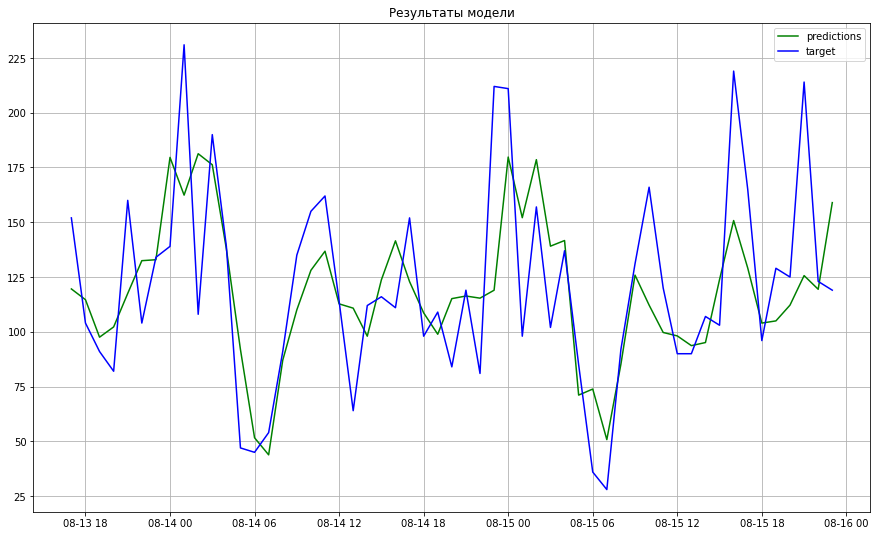

In [21]:
plt.figure(figsize=(15, 9))
plt.title('Результаты модели')
plt.grid(True)
plt.plot(predictions['2018-08-13':'2018-08-15'],
         color='green', label='predictions')
plt.plot(target_test['2018-08-13':'2018-08-15'],
         color='blue', label='target')
plt.legend()
plt.show()

41.77 < 48  
Следовательно, данная модель подходит под требуемые условия.  
И последним шагом станет проверка этой модели на адекватность с помощью сравнения с константной моделью.

In [22]:
const = np.ones(test.shape[0]) * train['num_orders'].mean()
mean_squared_error(target_test, const)**0.5

84.69779992674266

41.77 < 84.7  
Построенная нами модель полностью адекватна.

## Вывод
В результате работы мы построили несколько моделей для прогнозирования спроса на такси.
- Данные загружены и подготовлены
- Выполнено сравнение моделей с использованием различных наборов гиперпараметров.
- Выбрана лучшая модель по результатам метрики RMSE на кросс-валидации временного ряда.

Были использованы:
- CatBoostRegressor
- LightGBMRegressor

Наивысшие показатель метрики RMSE продемонстрировал LGBMRegressor.  
RMSE = 41.77